In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import random
import cv2
import os
import keras

Using TensorFlow backend.


##### Import Model params

In [2]:
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, Add, PReLU
from keras.layers import BatchNormalization, GlobalAveragePooling2D, Concatenate, GlobalMaxPool2D
from keras.regularizers import L1L2
from keras import Model

## Import data

In [2]:
def read_pickle_file(filepath):
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data['features'], data['labels']

In [3]:
X_train, Y_train = read_pickle_file(os.path.join('data', "train.p"))
X_val, Y_val = read_pickle_file(os.path.join('data', "valid.p"))
X_test, Y_test = read_pickle_file(os.path.join('data', "test.p"))

In [4]:
print('Train shape: {} \nValidation shape: {} \nTest shape: {}'.format(X_train.shape, X_val.shape, X_test.shape))

Train shape: (34799, 32, 32, 3) 
Validation shape: (4410, 32, 32, 3) 
Test shape: (12630, 32, 32, 3)


## Get Label values

In [5]:
data = pd.read_csv('data/signnames.csv')

## Display sample images for `43` classes

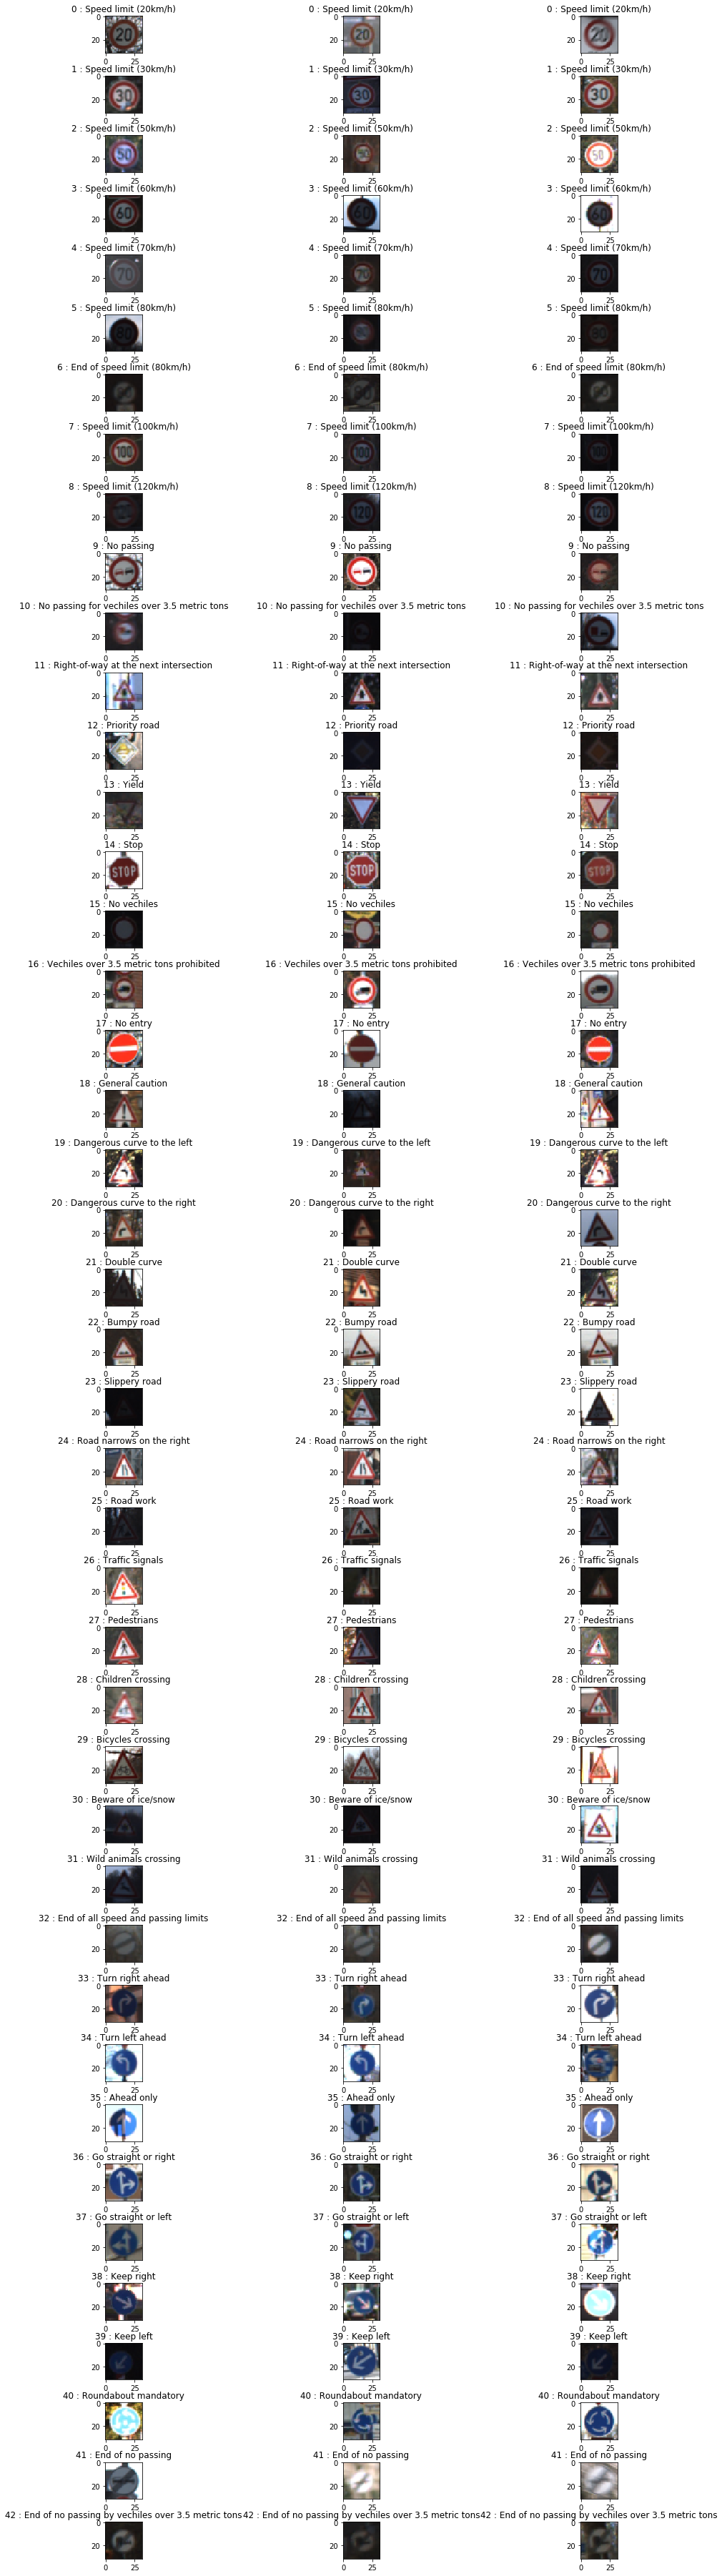

In [6]:
cols = 3
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(14, 50))
fig.tight_layout()

for i, row in data.iterrows():
    for j in range(cols):
        x_selected = X_train[Y_train == i]
        max_len = x_selected.shape[0] - 1
        
        axs[i][j].imshow(x_selected[random.randint(0, max_len), :, :])
        axs[i][j].set_title("{} : {}".format(i, row['SignName']))

## Understand the distribution of the Labels

*Distribution of Y_train, Y_val and Y_test are relatively same but there is many Labels which are unevenly distributed*

**We can understand that Labels are unevenly distributed and Class imbalance has to be tackled**

In [7]:
def plot_distribution(Y):
    label, counts = np.unique(Y, return_counts=True)
    plt.figure(figsize=(14,4))
    plt.bar(label, counts)
    plt.title('Distribution of Label')
    plt.xlabel('Classes')
    plt.ylabel('Frequency of Occurrence')

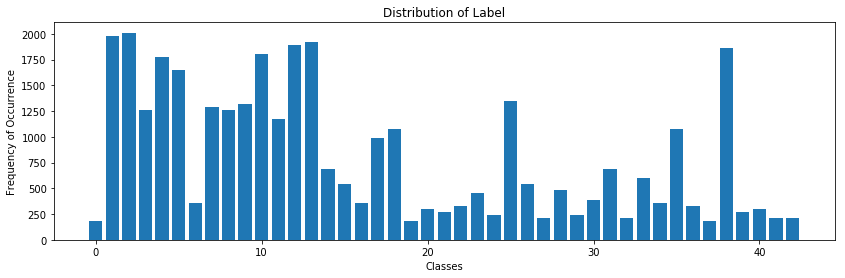

In [8]:
plot_distribution(Y_train)

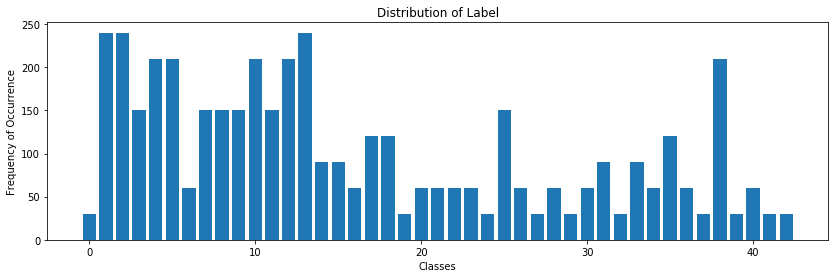

In [9]:
plot_distribution(Y_val)

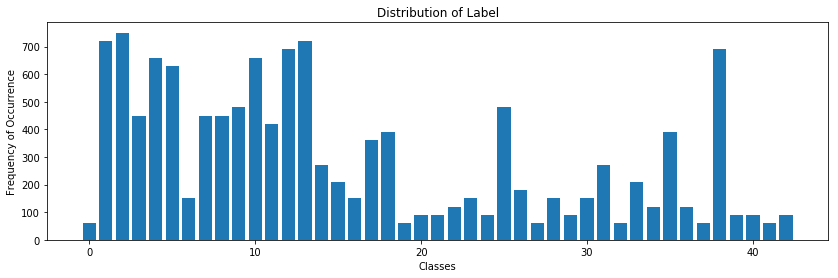

In [10]:
plot_distribution(Y_test)

## Image augmentation to tackle class imbalance

*Classes that can be flipped horizontally, vertically, flip along both axis, all the above*

* **Axis 0: vertical flip**
* **Axis 1: horizontal flip**
* **Axis -1: flip both axis**
* **Axis 2: All of the above**

In [11]:
class_map = {
#1: (1, 0) already has lot samples
5: (5, 0),
11: (11, 1),
# these 2 classes contain already many examples so we will skip them
# 12: (12, 2),
# 13: (13, 1),
15: (15, 2),
17: (17, 2),
18: (18, 1),
19: (20, 1),
20: (19, 1),
22: (22, 1),
26: (26, 1),
30: (30, 1),
32: (32, -1),
33: (34, 1),
34: (33, 1),
35: (35, 1),
36: (37, 1),
37: (36, 1),
38: (39, 1),
39: (38, 1),
40: (40, -1)
}

#### Find the class and flip the images

In [12]:
x_generated = []
y_generated = []

for actual_class, (class_val, axis) in class_map.items():
    ##filter samples having the index
    indices = np.where(Y_train == actual_class)[0]
    
    axis = (-1, 0, 1) if axis == 2 else (axis,)
    
    for ax in axis:
        ##use opencv
        x_generated.append(np.array(list(map(lambda x: cv2.flip(x, ax), X_train[indices].copy()))))
        #np full created an array with shape and values specified
        y_generated.append(np.full(shape=(len(indices),), fill_value=class_val, dtype=np.uint8))

**Check the augmented values**

Text(0.5,1,'Label value: 37 - Go straight or left')

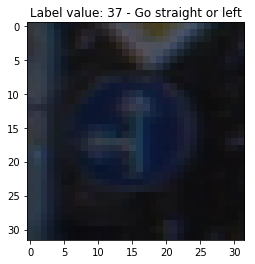

In [13]:
#get random key from class_val
import random
index = random.randint(0, len(class_map)-1)
label_value = y_generated[index][0]
img = x_generated[index][random.randint(0,len(x_generated[index]) -1 )]
plt.imshow(img)
plt.title('Label value: {} - {}'.format(label_value,data.loc[label_value, 'SignName']))

## Add the generated values to the X_train

In [14]:
X_train = np.concatenate([X_train] + x_generated, axis = 0)
Y_train = np.concatenate([Y_train] + y_generated, axis=0)

print(X_train.shape, Y_train.shape)

(50218, 32, 32, 3) (50218,)


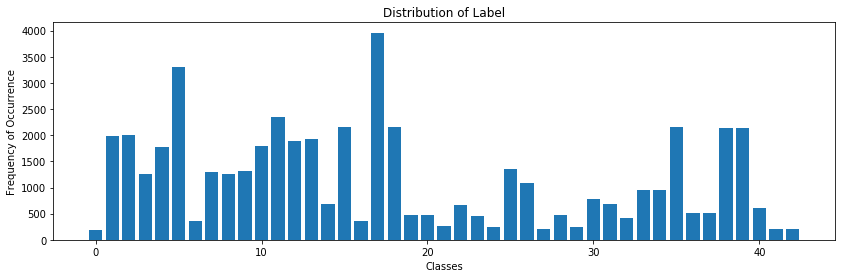

In [15]:
plot_distribution(Y_train)

## Random Undersampling

**Some Labels still have lot samples which can be removed by using random underSampling**

In [16]:
!pip install imblearn

twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
mkl-random 1.0.1 requires cython, which is not installed.
mkl-fft 1.0.4 requires cython, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [17]:
from imblearn.under_sampling import RandomUnderSampler 

In [18]:
d1, d2, d3, d4 = X_train.shape
X_train = X_train.reshape((d1, d2*d3*d4))

## Undersample classes which has number of samples more than 2000
a, b = np.unique(Y_train,return_counts=True)
under = {class_: 2000 for class_ in a if b[class_] > 2000}

ru = RandomUnderSampler(ratio=under)
X_train, Y_train = ru.fit_sample(X_train, Y_train)

X_train = np.reshape(X_train, (-1, 32, 32, 3))

## Re-sampled distribution

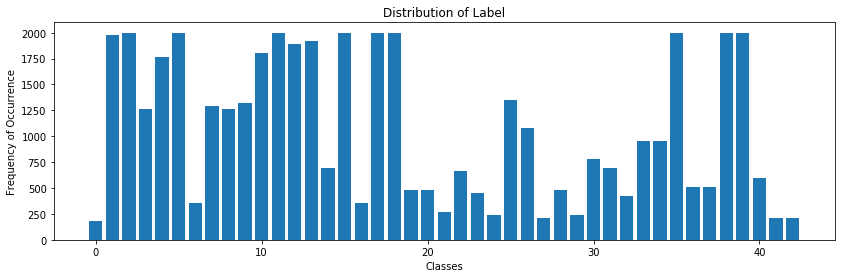

In [19]:
plot_distribution(Y_train)

## Image Pre processing

* RGB Histogram equalization: which causes uniform distribution of pixels 
* Grey scale Histogram equalization
* Image is normalized by 255, which reduces the exploding gradients, improves convergence speed

### RGB

In [20]:
def rgb_normalize(img):
    r = np.reshape(cv2.equalizeHist(img[:, :, 0]) / 255, (32, 32, 1))
    g = np.reshape(cv2.equalizeHist(img[:, :, 1]) / 255, (32, 32, 1))
    b = np.reshape(cv2.equalizeHist(img[:, :, 2]) / 255, (32, 32, 1))
    preprocessed_image = np.concatenate([r, g, b], axis=2)
    return preprocessed_image

In [21]:
rgb_train = np.array(list(map(lambda img: rgb_normalize(img), X_train)))
rgb_test = np.array(list(map(lambda img: rgb_normalize(img), X_test)))

In [22]:
rgb_train.shape

(45868, 32, 32, 3)

## Gray image

In [23]:
##convert rgb to gray scale
def gray_normalize(img):
    preprocessed_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    preprocessed_image = np.reshape(cv2.equalizeHist(preprocessed_image) / 255, (32, 32, 1))
    return preprocessed_image

In [24]:
gray_train = np.array(list(map(lambda img: gray_normalize(img), X_train)))
gray_test = np.array(list(map(lambda img: gray_normalize(img), X_test)))

In [25]:
gray_train.shape

(45868, 32, 32, 1)

## Final image check

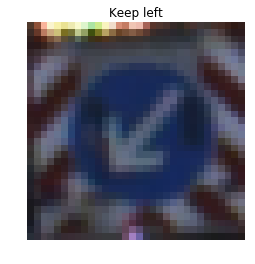

In [26]:
# Show a random image before preprocessing
index = random.randint(0, X_train.shape[0] - 1)
plt.imshow(X_train[index])
plt.axis("off")
plt.title(data["SignName"][Y_train[index]])
plt.show()

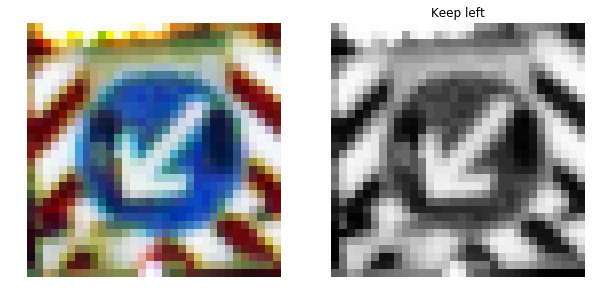

In [27]:
fig, plots = plt.subplots(1, 2, figsize=(10, 5))

plots[0].imshow(rgb_train[index].reshape(32,32, 3))
plots[0].axis("off")
plots[1].imshow(gray_train[index].reshape(32,32), cmap="gray")
plots[1].axis("off")
plt.title(data["SignName"][Y_train[index]])
plt.show()

## Augmentation using Keras

In [28]:
from keras.preprocessing.image import ImageDataGenerator

In [29]:
# data augmentation for rgb images
datagen = ImageDataGenerator(width_shift_range=0.25,
                             height_shift_range=0.25,
                             zoom_range=0.3,
                             shear_range=0.1,
                             rotation_range=10)

datagen.fit(rgb_train)

# data augmentation for gray scale images
datagen_gray = ImageDataGenerator(width_shift_range=0.25,
                                  height_shift_range=0.25,
                                  zoom_range=0.3,
                                  shear_range=0.1,
                                  rotation_range=10)

datagen_gray.fit(gray_train)

In [30]:
X_train.shape[0]

45868

Index: 28588: Dangerous curve to the right 


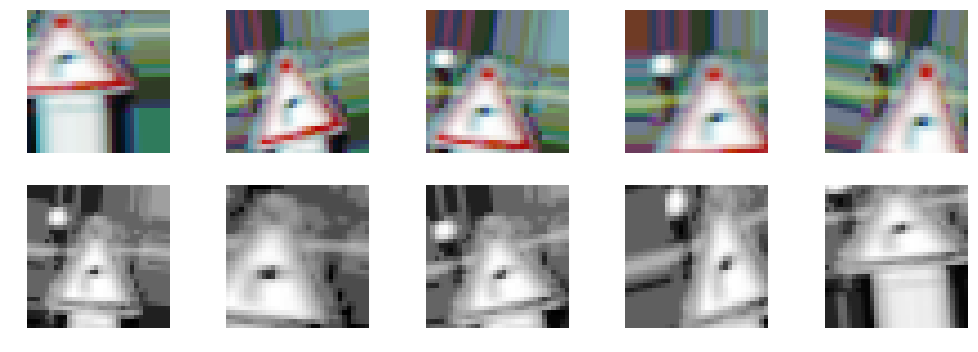

In [31]:
n = np.random.randint(0, X_train.shape[0] - 2)
print("Index: {}: {} ".format(n, data['SignName'][Y_train[n]]))

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
fig.tight_layout()

# rgb augmentation
for i, image in enumerate(datagen.flow(rgb_train[n:n+1], batch_size=1)):
    #only first 5 variants
    if i >= 5:
        break
    axs[0][i%5].imshow(image.reshape(32, 32, 3))
    axs[0][i%5].axis("off")

# gray scale images
for i, image in enumerate(datagen_gray.flow(gray_train[n:n+1], batch_size=1)):
    if i >= 5:
        break
    axs[1][i%5].imshow(image.reshape(32, 32), cmap='gray')
    axs[1][i%5].axis("off")

## Labels to one hot encoding

In [32]:
from keras.utils import to_categorical

In [33]:
Y_train = to_categorical(Y_train, 43)
Y_test = to_categorical(Y_test, 43)

# Label smoothening

**Advantage of Label smoothening:**
<br> It increases the generalization of the model by making the model to learn the soft targets rather than the hard targets and the soft targets are created using the weighted average of the hard targets and uniform distribution over the labels

<br> Soft targets are the ones which do not have 0s and 1s in the one hot encoded target, but rather have targets which has ~90% probability on the correct class and less probability on other class, making the model to be not so over confident about the prediction thus improving the generalization

In [37]:
def label_smoothening(labels, factor = 0.1):
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels

In [35]:
Y_train = label_smoothening(Y_train)
Y_test = label_smoothening(Y_test)

## Create metrics

In [10]:
from keras import backend as K


def f1_score(y_true, y_pred):
    """ F1 score metric """

    def recall_metric(labels, predictions):
        """ Recall metric """
        true_positives = K.sum(K.round(K.clip(labels * predictions, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(labels, 0, 1)))
        recall_score = true_positives / (possible_positives + K.epsilon())
        return recall_score

    def precision_metric(labels, predictions):
        """ Precision metric """
        true_positives = K.sum(K.round(K.clip(labels * predictions, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(predictions, 0, 1)))
        precision_score = true_positives / (predicted_positives + K.epsilon())
        return precision_score

    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)

    # K.epsilon() is a small number used to prevent division by zero
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

## Create `focal loss`

In [90]:
def focal_loss(gamma=2., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    
    def focal_loss_calc(y_true, y_pred):
        epsilon= 1e-09
        y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
        
        model_op = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_op))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_op), gamma)) #1-float
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    
    return focal_loss_calc

# Model

**Parametric Rectifier Unit Activation function**:
<br>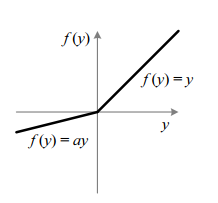

<br> This is similar to LeakyRelu, except the fact that the small positive value is learned along with the network so that the negative gradients are not ignored. The leanrning cost is negligible as the number of slope parameter == Number of layers which is the sum of the channels in the layer. 

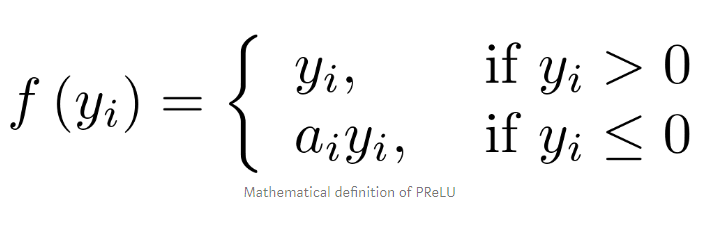

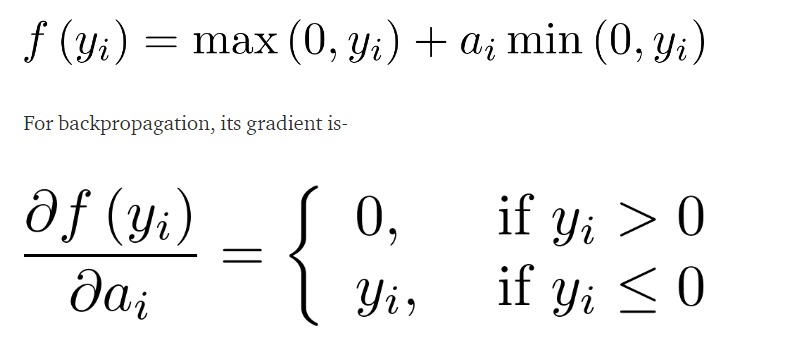

# Build Deep - CNN

**Kernel - 2D array and Filter - Number of Kernals**
<br> Kernels are usually odd numbers, since odd kernels capture the intensity of the center pic
<br> Num of filters is the number of the output channel, it combines the result of the kernels into a stack which has num_filters output values
<br> He_initialization is the recommended initializer for Relu - https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528 (which has why 2/fan_out is used in he_normal)

In [61]:
def conv_batch_prelu(name, tensor, num_filters,regularizers, prefix,kernel_size=(3,3), strides = (1,1), padding='same'):
    tensor = Conv2D(filters=num_filters, kernel_size=kernel_size, strides=strides,
                        kernel_initializer="he_uniform", bias_initializer="zeros",
                        kernel_regularizer=L1L2(regularizers[0], regularizers[1]),
                        padding=padding, name=prefix+"_conv_"+str(name))(tensor)
    tensor = BatchNormalization(momentum=0.1, name=prefix+"_batchnorm_"+str(name))(tensor)
    tensor = PReLU(shared_axes=[1, 2], name=prefix+"_prelu_"+str(name))(tensor)
    return tensor

In [81]:
def dense_batch_prelu(name, prefix, tensor, n_units):
        tensor = Dense(n_units, name=prefix+"_dense_"+str(name), kernel_initializer="he_uniform",
                       bias_initializer="zeros")(tensor)
        tensor = BatchNormalization(momentum=0.1, name=prefix+"_batchnorm_"+str(name))(tensor)
        tensor = PReLU(name=prefix+"_prelu_"+str(name))(tensor)
        return tensor

 # Deep CNN   

In [82]:
def deep_cnn(filters=64, input_shape=(32,32,3), regularizers=(0, 1e-5), num_classes=43, prefix="", 
             loss="categorical_crossentropy"):
    inp = Input(shape = input_shape, name = prefix+str("_input"))
    ##First layer
    cnn1 = conv_batch_prelu("cnn1", inp, num_filters=filters, regularizers = regularizers,prefix=prefix, kernel_size=(7,7), strides=(2,2))
    cnn2 = conv_batch_prelu("cnn2", cnn1, num_filters=filters//2, regularizers = regularizers, prefix=prefix,kernel_size=(5,5))
    max_pool1 = MaxPool2D(pool_size=(2, 2), name=prefix+str("_max_pool1"))(cnn2)
    
    ##Second layer
    cnn3 = conv_batch_prelu("cnn3", inp, num_filters=filters,regularizers=regularizers,prefix=prefix,kernel_size=(5,5), strides=(4,4))
    ##Third layer
    cnn4 = conv_batch_prelu("cnn4", inp, num_filters=filters,regularizers=regularizers,prefix=prefix,kernel_size=(7,7), strides=(8,8))
    
    ##Fourth layer concatenate
    concatenate1 = Concatenate(name=prefix+str("_concatenate1"))([cnn3, max_pool1])
    
    ##Fifth layer 
    cnn5 = conv_batch_prelu("cnn5", concatenate1, num_filters=filters, regularizers= regularizers,prefix=prefix,kernel_size=(5,5))
    max_pool2 = MaxPool2D(pool_size=(2,2), name = prefix+str("_max_pool2"))(cnn5)
    
    ##Sixth layer
    cnn6 = conv_batch_prelu("cnn6", concatenate1, num_filters=filters, regularizers= regularizers, prefix=prefix,kernel_size=(5,5),strides=(2,2))
    
    ##seventh layer
    concatenate2 = Concatenate(name=prefix+str("_concatenate2"))([cnn4, max_pool2, cnn6])
    
    ##Global layers
    avg_pool = GlobalAveragePooling2D(name=prefix+str("_avg_pool"))(concatenate2)
    fc1 = dense_batch_prelu("fc1", prefix,avg_pool, 1024)
    
    global_max_pool = GlobalMaxPool2D(name=prefix+str("_global_pool"))(concatenate2)
    fc2 = dense_batch_prelu("fc2", prefix,global_max_pool, 1024)
    
    ##Add
    add = Add(name=prefix+str("_add"))([fc1, fc2])
    drop1 = Dropout(0.4, name=prefix+str("_drop_1"))(add)
    
    ##FC3
    fc3 = dense_batch_prelu("fc3", prefix, drop1, 512)
    drop2 = Dropout(0.5, name=prefix+str("_drop2"))(fc3)
    
    ##Output Layer
    out = Dense(num_classes, activation="softmax", name=prefix+str("_output"))(drop2)
    
    ##Compile model
    model = Model(inp, out)
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy", f1_score])
    
    return model

### RGB Model train

In [83]:
rgb_model = deep_cnn(filters=64, input_shape=(32, 32, 3), regularizers=(1e-5, 1e-4), prefix="rgb")

In [85]:
gray_model = deep_cnn(filters=64, input_shape=(32, 32, 1), regularizers=(2e-5, 2e-4), prefix="gray")

In [89]:
foc_model = deep_cnn(filters=64, input_shape=(32, 32, 3), regularizers=(1e-5, 1e-4), prefix="foc",
                            loss=focal_loss(gamma=2., alpha=1.))

## Model Training

In [91]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [93]:
rgb_train.shape[0] // 128

358

In [97]:
# to avoid duplicates we create a function for the callbacks
def get_callbacks(prefix):
    callbacks =[
        ModelCheckpoint(filepath='models_saved/'+prefix+str('_best_weights_acc.hdf5'), mode="max",
                        verbose=1, save_best_only=True, monitor='val_acc'),
        #ReduceLROnPlateau(patience=50, monitor="val_acc", verbose=1,
        #                  factor=0.5, min_lr=5e-6, mode="max")
    ]
    return callbacks

batch_size = 128

# # training rgb model
print("Start training the rgb model...")
rgb_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size), verbose=0,
                        steps_per_epoch=rgb_train.shape[0] // batch_size * 10, epochs=1, shuffle=True)
rgb_history = rgb_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size),
                                      steps_per_epoch=rgb_train.shape[0] // batch_size // 40, epochs=700, 
                                      validation_data=(rgb_test, Y_test), verbose=0,
                                      shuffle=True, callbacks=get_callbacks("rgb"))

# training gray scale model
print("Start training the gray scale model...")
gray_model.fit_generator(datagen_gray.flow(gray_train, Y_train, batch_size=batch_size), verbose=0,
                         steps_per_epoch=gray_train.shape[0] // batch_size * 10, epochs=1, shuffle=True)
gray_history = gray_model.fit_generator(datagen_gray.flow(gray_train, Y_train, batch_size=batch_size),
                                        steps_per_epoch=gray_train.shape[0] // batch_size // 40, epochs=700, 
                                        validation_data=(gray_test, Y_test), verbose=0,
                                        shuffle=True, callbacks=get_callbacks("gray"))

# training foc model
print("Start training the foc model...")
foc_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size), verbose=0,
                        steps_per_epoch=rgb_train.shape[0] // batch_size * 10, epochs=1, shuffle=True)
foc_history = foc_model.fit_generator(datagen.flow(rgb_train, Y_train, batch_size=batch_size),
                                      steps_per_epoch=rgb_train.shape[0] // batch_size // 40, epochs=700, 
                                      validation_data=(rgb_test, Y_test), verbose=0,
                                      shuffle=True, callbacks=get_callbacks("foc"))

Start training the rgb model...

Epoch 00001: val_acc improved from -inf to 0.97743, saving model to models_saved/rgb_best_weights_acc.hdf5

Epoch 00002: val_acc improved from 0.97743 to 0.97751, saving model to models_saved/rgb_best_weights_acc.hdf5

Epoch 00003: val_acc did not improve from 0.97751

Epoch 00004: val_acc did not improve from 0.97751

Epoch 00005: val_acc did not improve from 0.97751

Epoch 00006: val_acc did not improve from 0.97751

Epoch 00007: val_acc did not improve from 0.97751

Epoch 00008: val_acc did not improve from 0.97751

Epoch 00009: val_acc did not improve from 0.97751

Epoch 00010: val_acc did not improve from 0.97751

Epoch 00011: val_acc did not improve from 0.97751

Epoch 00012: val_acc did not improve from 0.97751

Epoch 00013: val_acc did not improve from 0.97751

Epoch 00014: val_acc did not improve from 0.97751

Epoch 00015: val_acc did not improve from 0.97751

Epoch 00016: val_acc did not improve from 0.97751

Epoch 00017: val_acc did not impro


Epoch 00157: val_acc did not improve from 0.97989

Epoch 00158: val_acc did not improve from 0.97989

Epoch 00159: val_acc did not improve from 0.97989

Epoch 00160: val_acc did not improve from 0.97989

Epoch 00161: val_acc did not improve from 0.97989

Epoch 00162: val_acc did not improve from 0.97989

Epoch 00163: val_acc did not improve from 0.97989

Epoch 00164: val_acc did not improve from 0.97989

Epoch 00165: val_acc did not improve from 0.97989

Epoch 00166: val_acc did not improve from 0.97989

Epoch 00167: val_acc did not improve from 0.97989

Epoch 00168: val_acc did not improve from 0.97989

Epoch 00169: val_acc did not improve from 0.97989

Epoch 00170: val_acc did not improve from 0.97989

Epoch 00171: val_acc did not improve from 0.97989

Epoch 00172: val_acc did not improve from 0.97989

Epoch 00173: val_acc did not improve from 0.97989

Epoch 00174: val_acc did not improve from 0.97989

Epoch 00175: val_acc did not improve from 0.97989

Epoch 00176: val_acc did not i


Epoch 00317: val_acc did not improve from 0.98124

Epoch 00318: val_acc did not improve from 0.98124

Epoch 00319: val_acc did not improve from 0.98124

Epoch 00320: val_acc did not improve from 0.98124

Epoch 00321: val_acc did not improve from 0.98124

Epoch 00322: val_acc did not improve from 0.98124

Epoch 00323: val_acc did not improve from 0.98124

Epoch 00324: val_acc did not improve from 0.98124

Epoch 00325: val_acc did not improve from 0.98124

Epoch 00326: val_acc did not improve from 0.98124

Epoch 00327: val_acc did not improve from 0.98124

Epoch 00328: val_acc did not improve from 0.98124

Epoch 00329: val_acc did not improve from 0.98124

Epoch 00330: val_acc did not improve from 0.98124

Epoch 00331: val_acc did not improve from 0.98124

Epoch 00332: val_acc did not improve from 0.98124

Epoch 00333: val_acc did not improve from 0.98124

Epoch 00334: val_acc did not improve from 0.98124

Epoch 00335: val_acc did not improve from 0.98124

Epoch 00336: val_acc did not i


Epoch 00478: val_acc did not improve from 0.98124

Epoch 00479: val_acc did not improve from 0.98124

Epoch 00480: val_acc did not improve from 0.98124

Epoch 00481: val_acc did not improve from 0.98124

Epoch 00482: val_acc did not improve from 0.98124

Epoch 00483: val_acc did not improve from 0.98124

Epoch 00484: val_acc did not improve from 0.98124

Epoch 00485: val_acc did not improve from 0.98124

Epoch 00486: val_acc did not improve from 0.98124

Epoch 00487: val_acc did not improve from 0.98124

Epoch 00488: val_acc did not improve from 0.98124

Epoch 00489: val_acc did not improve from 0.98124

Epoch 00490: val_acc did not improve from 0.98124

Epoch 00491: val_acc did not improve from 0.98124

Epoch 00492: val_acc did not improve from 0.98124

Epoch 00493: val_acc did not improve from 0.98124

Epoch 00494: val_acc did not improve from 0.98124

Epoch 00495: val_acc did not improve from 0.98124

Epoch 00496: val_acc did not improve from 0.98124

Epoch 00497: val_acc did not i


Epoch 00637: val_acc did not improve from 0.98306

Epoch 00638: val_acc did not improve from 0.98306

Epoch 00639: val_acc did not improve from 0.98306

Epoch 00640: val_acc did not improve from 0.98306

Epoch 00641: val_acc did not improve from 0.98306

Epoch 00642: val_acc did not improve from 0.98306

Epoch 00643: val_acc did not improve from 0.98306

Epoch 00644: val_acc did not improve from 0.98306

Epoch 00645: val_acc did not improve from 0.98306

Epoch 00646: val_acc did not improve from 0.98306

Epoch 00647: val_acc did not improve from 0.98306

Epoch 00648: val_acc did not improve from 0.98306

Epoch 00649: val_acc did not improve from 0.98306

Epoch 00650: val_acc did not improve from 0.98306

Epoch 00651: val_acc did not improve from 0.98306

Epoch 00652: val_acc did not improve from 0.98306

Epoch 00653: val_acc did not improve from 0.98306

Epoch 00654: val_acc did not improve from 0.98306

Epoch 00655: val_acc did not improve from 0.98306

Epoch 00656: val_acc did not i


Epoch 00091: val_acc improved from 0.96722 to 0.96762, saving model to models_saved/gray_best_weights_acc.hdf5

Epoch 00092: val_acc did not improve from 0.96762

Epoch 00093: val_acc did not improve from 0.96762

Epoch 00094: val_acc did not improve from 0.96762

Epoch 00095: val_acc did not improve from 0.96762

Epoch 00096: val_acc did not improve from 0.96762

Epoch 00097: val_acc did not improve from 0.96762

Epoch 00098: val_acc did not improve from 0.96762

Epoch 00099: val_acc did not improve from 0.96762

Epoch 00100: val_acc did not improve from 0.96762

Epoch 00101: val_acc did not improve from 0.96762

Epoch 00102: val_acc did not improve from 0.96762

Epoch 00103: val_acc did not improve from 0.96762

Epoch 00104: val_acc did not improve from 0.96762

Epoch 00105: val_acc did not improve from 0.96762

Epoch 00106: val_acc did not improve from 0.96762

Epoch 00107: val_acc did not improve from 0.96762

Epoch 00108: val_acc did not improve from 0.96762

Epoch 00109: val_acc


Epoch 00247: val_acc did not improve from 0.96865

Epoch 00248: val_acc did not improve from 0.96865

Epoch 00249: val_acc did not improve from 0.96865

Epoch 00250: val_acc did not improve from 0.96865

Epoch 00251: val_acc did not improve from 0.96865

Epoch 00252: val_acc did not improve from 0.96865

Epoch 00253: val_acc did not improve from 0.96865

Epoch 00254: val_acc did not improve from 0.96865

Epoch 00255: val_acc did not improve from 0.96865

Epoch 00256: val_acc did not improve from 0.96865

Epoch 00257: val_acc did not improve from 0.96865

Epoch 00258: val_acc did not improve from 0.96865

Epoch 00259: val_acc did not improve from 0.96865

Epoch 00260: val_acc did not improve from 0.96865

Epoch 00261: val_acc did not improve from 0.96865

Epoch 00262: val_acc did not improve from 0.96865

Epoch 00263: val_acc did not improve from 0.96865

Epoch 00264: val_acc did not improve from 0.96865

Epoch 00265: val_acc improved from 0.96865 to 0.96920, saving model to models_sav


Epoch 00406: val_acc did not improve from 0.97102

Epoch 00407: val_acc did not improve from 0.97102

Epoch 00408: val_acc did not improve from 0.97102

Epoch 00409: val_acc did not improve from 0.97102

Epoch 00410: val_acc did not improve from 0.97102

Epoch 00411: val_acc did not improve from 0.97102

Epoch 00412: val_acc did not improve from 0.97102

Epoch 00413: val_acc did not improve from 0.97102

Epoch 00414: val_acc did not improve from 0.97102

Epoch 00415: val_acc did not improve from 0.97102

Epoch 00416: val_acc did not improve from 0.97102

Epoch 00417: val_acc did not improve from 0.97102

Epoch 00418: val_acc did not improve from 0.97102

Epoch 00419: val_acc did not improve from 0.97102

Epoch 00420: val_acc did not improve from 0.97102

Epoch 00421: val_acc did not improve from 0.97102

Epoch 00422: val_acc did not improve from 0.97102

Epoch 00423: val_acc did not improve from 0.97102

Epoch 00424: val_acc did not improve from 0.97102

Epoch 00425: val_acc did not i


Epoch 00566: val_acc did not improve from 0.97332

Epoch 00567: val_acc did not improve from 0.97332

Epoch 00568: val_acc did not improve from 0.97332

Epoch 00569: val_acc did not improve from 0.97332

Epoch 00570: val_acc did not improve from 0.97332

Epoch 00571: val_acc did not improve from 0.97332

Epoch 00572: val_acc did not improve from 0.97332

Epoch 00573: val_acc did not improve from 0.97332

Epoch 00574: val_acc did not improve from 0.97332

Epoch 00575: val_acc did not improve from 0.97332

Epoch 00576: val_acc did not improve from 0.97332

Epoch 00577: val_acc did not improve from 0.97332

Epoch 00578: val_acc did not improve from 0.97332

Epoch 00579: val_acc did not improve from 0.97332

Epoch 00580: val_acc did not improve from 0.97332

Epoch 00581: val_acc did not improve from 0.97332

Epoch 00582: val_acc did not improve from 0.97332

Epoch 00583: val_acc did not improve from 0.97332

Epoch 00584: val_acc did not improve from 0.97332

Epoch 00585: val_acc did not i


Epoch 00017: val_acc did not improve from 0.95273

Epoch 00018: val_acc improved from 0.95273 to 0.95463, saving model to models_saved/foc_best_weights_acc.hdf5

Epoch 00019: val_acc improved from 0.95463 to 0.96017, saving model to models_saved/foc_best_weights_acc.hdf5

Epoch 00020: val_acc did not improve from 0.96017

Epoch 00021: val_acc did not improve from 0.96017

Epoch 00022: val_acc did not improve from 0.96017

Epoch 00023: val_acc did not improve from 0.96017

Epoch 00024: val_acc did not improve from 0.96017

Epoch 00025: val_acc did not improve from 0.96017

Epoch 00026: val_acc did not improve from 0.96017

Epoch 00027: val_acc did not improve from 0.96017

Epoch 00028: val_acc did not improve from 0.96017

Epoch 00029: val_acc did not improve from 0.96017

Epoch 00030: val_acc did not improve from 0.96017

Epoch 00031: val_acc did not improve from 0.96017

Epoch 00032: val_acc did not improve from 0.96017

Epoch 00033: val_acc did not improve from 0.96017

Epoch 00034:


Epoch 00172: val_acc did not improve from 0.96485

Epoch 00173: val_acc did not improve from 0.96485

Epoch 00174: val_acc did not improve from 0.96485

Epoch 00175: val_acc did not improve from 0.96485

Epoch 00176: val_acc did not improve from 0.96485

Epoch 00177: val_acc did not improve from 0.96485

Epoch 00178: val_acc did not improve from 0.96485

Epoch 00179: val_acc did not improve from 0.96485

Epoch 00180: val_acc did not improve from 0.96485

Epoch 00181: val_acc did not improve from 0.96485

Epoch 00182: val_acc did not improve from 0.96485

Epoch 00183: val_acc did not improve from 0.96485

Epoch 00184: val_acc did not improve from 0.96485

Epoch 00185: val_acc did not improve from 0.96485

Epoch 00186: val_acc did not improve from 0.96485

Epoch 00187: val_acc did not improve from 0.96485

Epoch 00188: val_acc did not improve from 0.96485

Epoch 00189: val_acc did not improve from 0.96485

Epoch 00190: val_acc did not improve from 0.96485

Epoch 00191: val_acc improved 


Epoch 00331: val_acc did not improve from 0.97237

Epoch 00332: val_acc did not improve from 0.97237

Epoch 00333: val_acc did not improve from 0.97237

Epoch 00334: val_acc did not improve from 0.97237

Epoch 00335: val_acc did not improve from 0.97237

Epoch 00336: val_acc did not improve from 0.97237

Epoch 00337: val_acc did not improve from 0.97237

Epoch 00338: val_acc did not improve from 0.97237

Epoch 00339: val_acc did not improve from 0.97237

Epoch 00340: val_acc did not improve from 0.97237

Epoch 00341: val_acc did not improve from 0.97237

Epoch 00342: val_acc did not improve from 0.97237

Epoch 00343: val_acc did not improve from 0.97237

Epoch 00344: val_acc did not improve from 0.97237

Epoch 00345: val_acc did not improve from 0.97237

Epoch 00346: val_acc did not improve from 0.97237

Epoch 00347: val_acc did not improve from 0.97237

Epoch 00348: val_acc did not improve from 0.97237

Epoch 00349: val_acc did not improve from 0.97237

Epoch 00350: val_acc did not i


Epoch 00492: val_acc did not improve from 0.97237

Epoch 00493: val_acc did not improve from 0.97237

Epoch 00494: val_acc did not improve from 0.97237

Epoch 00495: val_acc did not improve from 0.97237

Epoch 00496: val_acc did not improve from 0.97237

Epoch 00497: val_acc did not improve from 0.97237

Epoch 00498: val_acc did not improve from 0.97237

Epoch 00499: val_acc did not improve from 0.97237

Epoch 00500: val_acc did not improve from 0.97237

Epoch 00501: val_acc did not improve from 0.97237

Epoch 00502: val_acc did not improve from 0.97237

Epoch 00503: val_acc did not improve from 0.97237

Epoch 00504: val_acc did not improve from 0.97237

Epoch 00505: val_acc did not improve from 0.97237

Epoch 00506: val_acc did not improve from 0.97237

Epoch 00507: val_acc did not improve from 0.97237

Epoch 00508: val_acc did not improve from 0.97237

Epoch 00509: val_acc did not improve from 0.97237

Epoch 00510: val_acc did not improve from 0.97237

Epoch 00511: val_acc did not i


Epoch 00651: val_acc did not improve from 0.97648

Epoch 00652: val_acc did not improve from 0.97648

Epoch 00653: val_acc did not improve from 0.97648

Epoch 00654: val_acc did not improve from 0.97648

Epoch 00655: val_acc did not improve from 0.97648

Epoch 00656: val_acc did not improve from 0.97648

Epoch 00657: val_acc did not improve from 0.97648

Epoch 00658: val_acc did not improve from 0.97648

Epoch 00659: val_acc did not improve from 0.97648

Epoch 00660: val_acc did not improve from 0.97648

Epoch 00661: val_acc did not improve from 0.97648

Epoch 00662: val_acc did not improve from 0.97648

Epoch 00663: val_acc did not improve from 0.97648

Epoch 00664: val_acc did not improve from 0.97648

Epoch 00665: val_acc did not improve from 0.97648

Epoch 00666: val_acc did not improve from 0.97648

Epoch 00667: val_acc did not improve from 0.97648

Epoch 00668: val_acc did not improve from 0.97648

Epoch 00669: val_acc did not improve from 0.97648

Epoch 00670: val_acc did not i

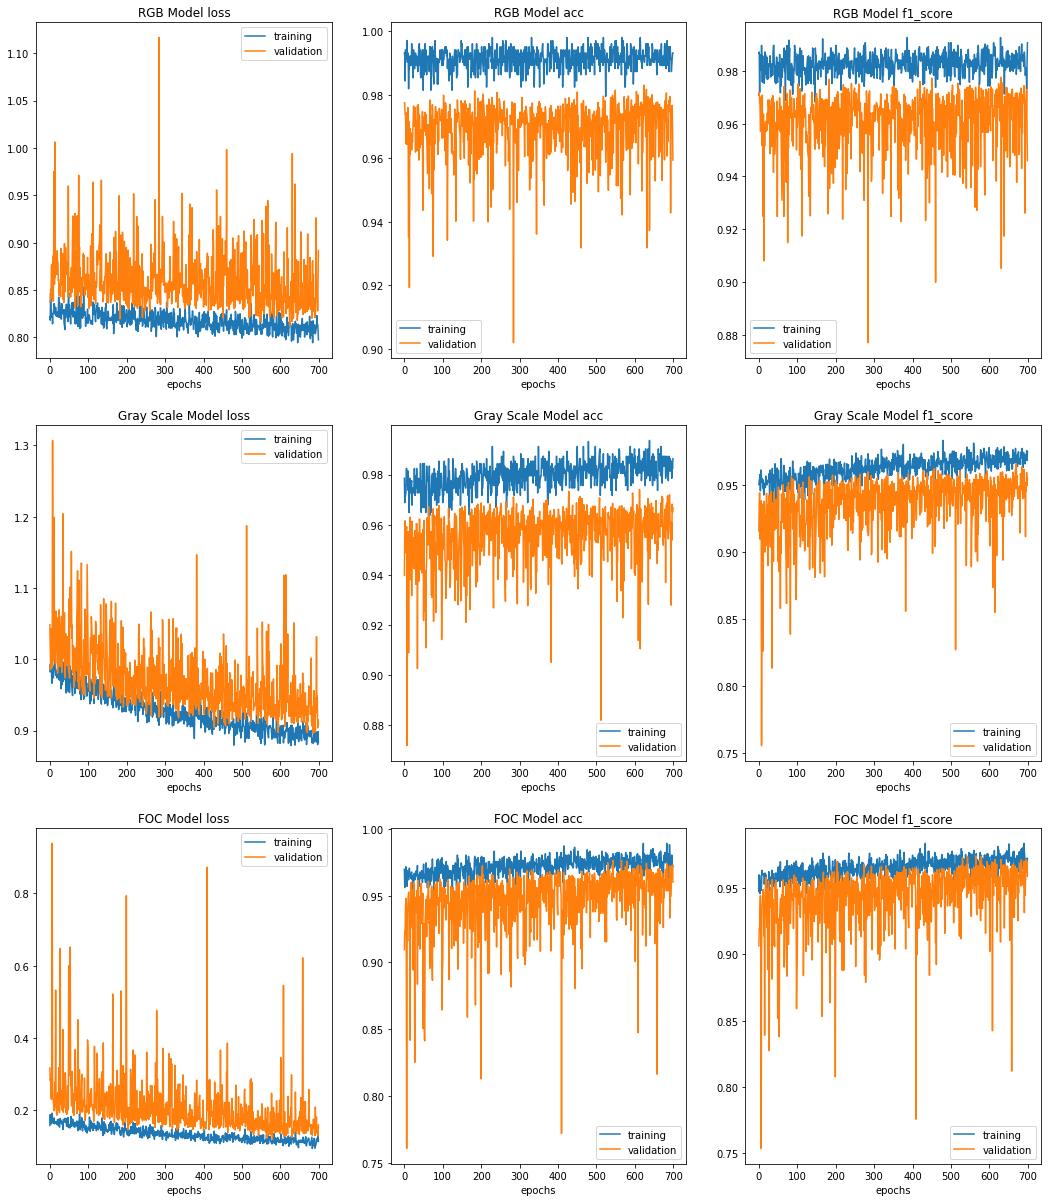

In [98]:
fig, axs = plt.subplots(3, 3, figsize=(18, 21))

for i, name in enumerate(["loss", "acc", "f1_score"]):
    # rgb model history
    axs[0][i].plot(rgb_history.history[name])
    axs[0][i].plot(rgb_history.history[f"val_{name}"])
    axs[0][i].legend(["training", "validation"])
    axs[0][i].set_title(f"RGB Model {name}")
    axs[0][i].set_xlabel("epochs")
    
    # gray scale model history
    axs[1][i].plot(gray_history.history[name])
    axs[1][i].plot(gray_history.history[f"val_{name}"])
    axs[1][i].legend(["training", "validation"])
    axs[1][i].set_title(f"Gray Scale Model {name}")
    axs[1][i].set_xlabel("epochs")
    
    # foc model history
    axs[2][i].plot(foc_history.history[name])
    axs[2][i].plot(foc_history.history[f"val_{name}"])
    axs[2][i].legend(["training", "validation"])
    axs[2][i].set_title(f"FOC Model {name}")
    axs[2][i].set_xlabel("epochs")

plt.show()

In [13]:
from keras.models import load_model

rgb_model = load_model('models_saved/rgb_best_weights_acc.hdf5')
score = rgb_model.evaluate(rgb_test, Y_test, verbose=1)
print(f"Test Score: {score[0]}\nTest Accuracy: {score[1]}\nTest F1_score: {score[2]}")

gray_model = load_model('models_saved/gray_best_weights_acc.hdf5')
score = gray_model.evaluate(gray_test, Y_test, verbose=1)
print(f"Test Score: {score[0]}\nTest Accuracy: {score[1]}\nTest F1_score: {score[2]}")

foc_model = load_model('models_saved/foc_best_weights_acc.hdf5')
score = foc_model.evaluate(rgb_test, Y_test, verbose=1)
print(f"Test Score: {score[0]}\nTest Accuracy: {score[1]}\nTest F1_score: {score[2]}")